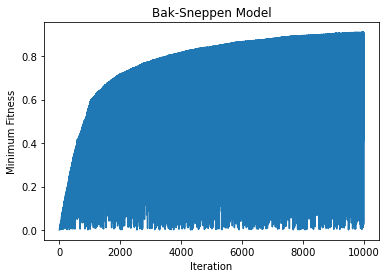

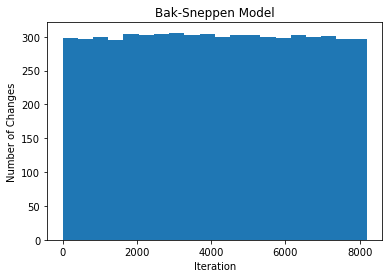

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def bak_sneppen_1D(n_iterations):
    # Initialize the system
    n_sites = 1000
    fitness = np.random.rand(n_sites)
    threshold = 0.6
    evolution = np.zeros(n_iterations)
    changes = []
    fitness_changes = []
    time = [0]

    for i in range(n_iterations):
        min_index = np.argmin(fitness)

        fitness_changes.append(fitness[min_index])

        # Assign a new random fitness value to the selected lowest fitness species
        fitness[min_index] = np.random.rand()

        if fitness[min_index] < threshold:
            changes.append(i)
            time.append(time[-1] + np.exp(fitness[min_index]))

        # change neighbors' fitness values if they are below the threshold
        if min_index > 0 and fitness[min_index - 1] < threshold:
            fitness[min_index - 1] = np.random.rand()
        elif min_index == 0 and fitness[n_sites - 1] < threshold:
            fitness[n_sites - 1] = np.random.rand()
        if min_index < n_sites - 1 and fitness[min_index + 1] < threshold:
            fitness[min_index + 1] = np.random.rand()
        elif min_index == n_sites - 1 and fitness[0] < threshold:
            fitness[0] = np.random.rand()

        # Record the minimum fitness value at each iteration
        evolution[i] = np.min(fitness)

    return evolution, changes, time

# Run the Bak-Sneppen simulation
n_iterations = 10000
evolution, changes, time = bak_sneppen_1D(n_iterations)

# Plot the evolution of the minimum fitness value
plt.plot(range(n_iterations), evolution)
plt.xlabel('Iteration')
plt.ylabel('Minimum Fitness')
plt.title('Bak-Sneppen Model')
plt.show()

# plot the histogram of the changes
plt.hist(time, bins=20)
plt.xlabel('Iteration')
plt.ylabel('Number of Changes')
plt.title('Bak-Sneppen Model')
plt.show()